In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as py


df=pd.read_csv("https://raw.githubusercontent.com/feldob/Token-Cluster-Generator/master/instances/1.txt",sep=" ")

### **Exploratory Data Analysis**

In [2]:
df=df.drop(columns="Cluster",axis=1)

In [3]:
py.scatter(df,df.X,df.Y)

In [4]:
df.isnull().sum()

X    0
Y    0
dtype: int64

In [5]:
df.isna().sum()

X    0
Y    0
dtype: int64

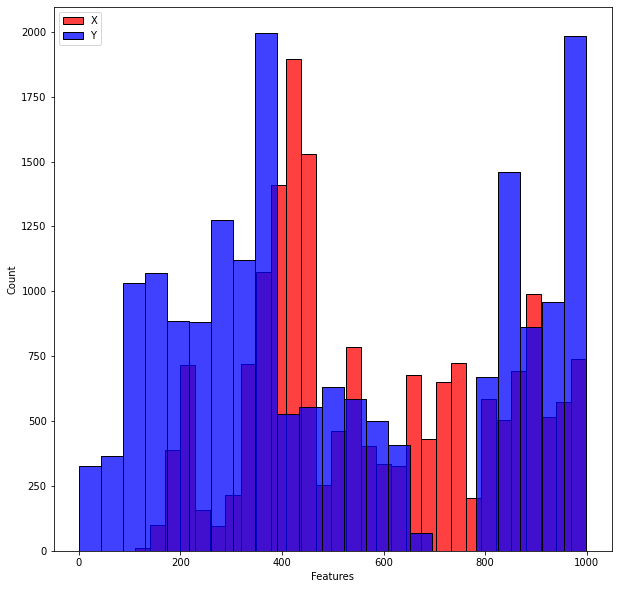

In [6]:
plt.figure(figsize=(10,10))
sns.histplot(df.X,color="r",label="X")
sns.histplot(df.Y,color="b",label="Y")
plt.xlabel("Features")
plt.legend()
plt.show()

In [7]:
df.describe()

,X,Y
count,18161.000000,18161.000000
mean,578.709597,508.428335
std,231.688508,308.636951
min,111.000000,0.000000
25%,400.000000,259.000000
50%,528.000000,402.000000
75%,795.000000,843.000000
max,999.000000,999.000000


From the Bar plots above, and after describing the dataset, We can see that X and Y features are not within the same range of values with different means and standard deviation, in addition that the minimum value reached in X is 111 while in Y is 0. 
This may affect affect the results of our clustering models while computing distances measures like Manhattan and Euclidian ones.


That is why we will know normalize our data using the <strong>StandardScaler</strong> method in sklearn.


In [8]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

df_norm=scaler.fit_transform(df[["X","Y"]])

In [9]:
df_norm=pd.DataFrame(df_norm,columns=["X_Norm","Y_Norm"])

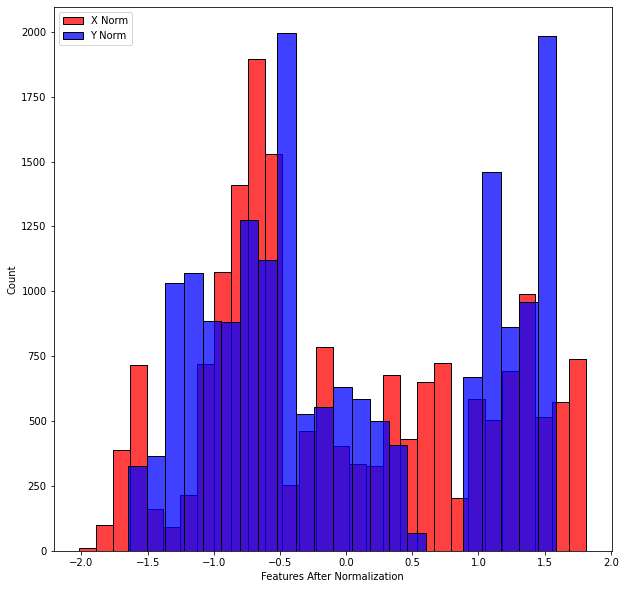

In [10]:
plt.figure(figsize=(10,10))
sns.histplot(df_norm.X_Norm,color="r",label="X Norm")
sns.histplot(df_norm.Y_Norm,color="b",label="Y Norm")
plt.xlabel("Features After Normalization")
plt.legend()
plt.show()

In [11]:
df_norm.describe()

,X_Norm,Y_Norm
count,1.816100e+04,1.816100e+04
mean,-9.865304e-15,2.495174e-16
std,1.000028e+00,1.000028e+00
min,-2.018756e+00,-1.647380e+00
25%,-7.713569e-01,-8.081832e-01
50%,-2.188757e-01,-3.448429e-01
75%,9.335653e-01,1.084060e+00
max,1.814082e+00,1.589522e+00


# KMeans Clustering


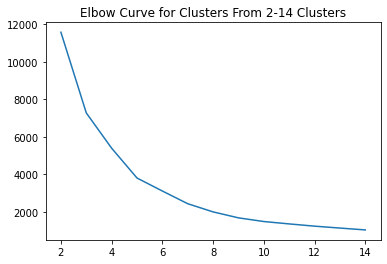

In [12]:
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering,MiniBatchKMeans,MeanShift
from sklearn.metrics import silhouette_score,davies_bouldin_score


n_clusters=[i for i in range(2,15)]

inertias=[]
scores={}

for n_cluster in n_clusters:
  k_mean=KMeans(n_cluster)
  pred=k_mean.fit_predict(df_norm)
  inertias.append(k_mean.inertia_)
  
plt.title("Elbow Curve for Clusters From 2-14 Clusters")
plt.plot(n_clusters,inertias)

From the Elbow Curve convergence above and from a visual perception of the scatter plot distribution of the points, We can conclude the the optimial number of clusters are within the interval [4,5].


We will closer analyze the number within this specific number of clusters and we will use a custom metric which takes into consideration the inertia, the silhouette score with different distance measure (euclidian | manhattan | cosine) and the davies_bouldin.

Here is the formula of the custom metric:
## <strong>custom_score= 1/log(inertia) + silhouette_score(euclidian, manhattan, cosine) + 1/davies_bouldin</strong>

In the addition formula, I added the inverse of the inertia and davies_bouldin scores since the smaller the values, the better the clustering is. 

The log in the inertia is added since we may from the plotted elbow curve above that the inertia is within a big range of values so the logarithm here is too reduce that range.







In [13]:
def compute_score(inertia,silhouette_euclidian,silhouette_manhattan,silhouette_cosine,davies_bouldin):
  return silhouette_euclidian+silhouette_manhattan +silhouette_cosine+ 1/np.log(inertia)+ 1/davies_bouldin

In [14]:
n_clusters=[i for i in range(4,6)]

scores=[]
for n_cluster in n_clusters:
  k_mean=KMeans(n_cluster)
  pred=k_mean.fit_predict(df_norm)
  
  inertia=k_mean.inertia_
  silhouette_euclidian=silhouette_score(df_norm,pred)
  silhouette_manhattan=silhouette_score(df_norm,pred,metric="manhattan")
  silhouette_cosine=silhouette_score(df_norm,pred,metric="cosine")
  davies_bouldin=davies_bouldin_score(df_norm,pred)

  scores.append(compute_score(inertia,silhouette_euclidian,silhouette_manhattan,silhouette_cosine,davies_bouldin))

print(f"Scores Computed {scores}")
print(np.argmax(scores)+4)


Scores Computed [2.812418414443438, 2.838343990106768]
5


In [15]:
k_mean_optimal=KMeans(5,n_init=100,max_iter=1000)

labels=k_mean_optimal.fit_predict(df_norm[["X_Norm","Y_Norm"]])
df_norm_5=df_norm.copy()
df_norm_5["labels"]=labels

py.scatter(df_norm_5,df_norm_5.X_Norm,df_norm_5.Y_Norm,color=df_norm_5.labels)

We can see fromthe above plot that some of the clusters are not well seperated, in addition the points on the in the upper left which visually should form a cluster on their own but were assigned to another one. 

We will now try to explore other clustering scenarios by adding polynomial features of degree 2.

#Adding Polynomial Features


In [16]:
from sklearn.preprocessing import PolynomialFeatures 

poly_2=PolynomialFeatures(2)
df_norm_poly=pd.DataFrame(poly_2.fit_transform(df_norm),columns=["Bias","X_Norm","Y_Norm","X_Norm2","X*Y_Norm","Y_Norm2"])

In [17]:
df_norm_poly

,Bias,X_Norm,Y_Norm,X_Norm2,X*Y_Norm,Y_Norm2
0,1.0,-2.018756,1.527959,4.075374,-3.084576,2.334659
1,1.0,-1.992858,1.570081,3.971483,-3.128949,2.465154
2,1.0,-2.005807,1.531199,4.023261,-3.071290,2.344571
3,1.0,-1.962644,1.521479,3.851972,-2.986122,2.314898
4,1.0,-1.979909,1.579801,3.920041,-3.127863,2.495772
...,...,...,...,...,...,...
18156,1.0,1.663013,1.009536,2.765612,1.678872,1.019164
18157,1.0,1.663013,1.041938,2.765612,1.732756,1.085634
18158,1.0,1.663013,1.032217,2.765612,1.716591,1.065473
18159,1.0,1.663013,0.993336,2.765612,1.651930,0.986716


In [18]:
py.scatter_3d(df_norm_poly,df_norm_poly.X_Norm,df_norm_poly.Y_Norm,df_norm_poly.Y_Norm2)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



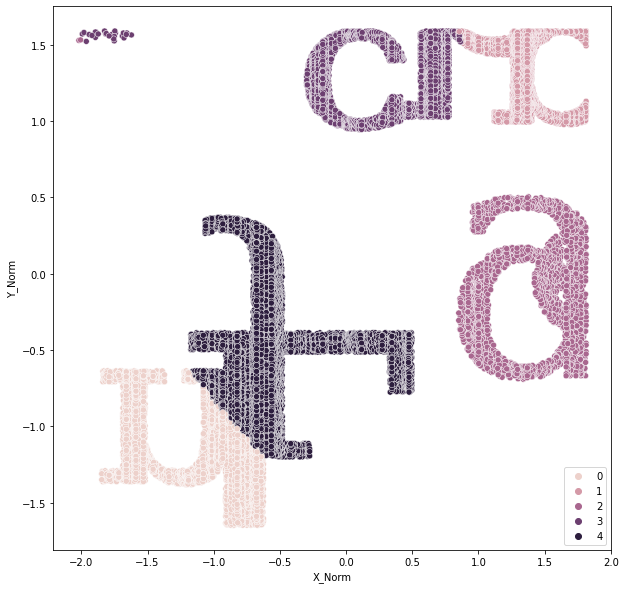

In [19]:
k_mean=KMeans(5)
pred=k_mean.fit_predict(df_norm_poly[["X_Norm","Y_Norm","X_Norm2","Y_Norm2","X*Y_Norm"]])

plt.figure(figsize=(10,10))
sns.scatterplot(df_norm_poly.X_Norm,df_norm_poly.Y_Norm,hue=pred)
plt.legend(loc="lower right")

We see that even by adding polynomial features, the distribution of the clusters did not change that much. 

We will now try other sets of clustering algorithms. 


#DBSCAN

We will now explore another clustering model which is the Density-Based Spatial Clustering of Applications with Noise. 

To evaluate this model we will use the same custom score as before but this time we will take off the inertia from it. 

<strong>custom_score=silouette_score(euclididan,manhattan,cosine) + 1/davies_bouldin</strong>
since the smaller the davies boudin score the better then we apply the inverse to that score and add it to our custom score equation for evaluation


In [20]:
def custom_score(sil_euclidan,sil_manhattan,sil_cosine,davies_bouldin):
  return sil_euclidian+sil_manhattan+sil_cosine+1/davies_bouldin

In [21]:
from tqdm import tqdm

eps=[i for i in np.linspace(0.01,1,100)]

min_samples=[i for i in range(2,17)]
best_dbscan_mean=None
best_score=0

for ep in tqdm(eps):
  for min_sample in min_samples:
    try:
      dbscan_model=DBSCAN(ep,min_sample)
      pred=dbscan_model.fit_predict(df_norm_poly[["X_Norm","Y_Norm","X_Norm2","Y_Norm2"]]) 
      sil_euclidian=silhouette_score(df_norm,pred)
      sil_manhattan=silhouette_score(df_norm,pred,metric="manhattan")
      sil_cosine=silhouette_score(df_norm,pred,metric="cosine")
      davies_bouldin=davies_bouldin_score(df_norm,pred)
      if len(pred[pred==-1])<150:
        if round(custom_score(sil_euclidian,sil_manhattan,sil_cosine,davies_bouldin),2)>best_score:
          try:
            print(f"{ep}   {min_sample}")
            best_score=round(custom_score(silhouette_euclidian,silhouette_manhattan,silhouette_cosine,davies_bouldin),2)
            print(best_score)
            bes_dbscan_mean=dbscan_model   
          except Exception as e:
            pass 
    
    except Exception as e:
        pass


  4%|▍         | 4/100 [08:47<3:19:53, 124.93s/it]

0.05   3
2.03


  6%|▌         | 6/100 [14:03<3:42:27, 142.00s/it]

0.06999999999999999   3
2.47


  7%|▋         | 7/100 [16:45<3:49:36, 148.13s/it]

0.08   2
2.25
0.08   4
3.42
0.08   5
3.42
0.08   6
3.35


  8%|▊         | 8/100 [19:29<3:54:17, 152.80s/it]

0.09   5
3.42
0.09   6
3.42
0.09   7
3.42


  9%|▉         | 9/100 [22:14<3:57:06, 156.33s/it]

0.09999999999999999   6
3.42
0.09999999999999999   7
3.42


 10%|█         | 10/100 [24:58<3:58:05, 158.73s/it]

0.11   7
3.42
0.11   8
3.42
0.11   9
3.42
0.11   10
3.42


 11%|█         | 11/100 [27:43<3:58:10, 160.57s/it]

0.12   7
3.42
0.12   8
3.42
0.12   9
3.42
0.12   10
3.42


 12%|█▏        | 12/100 [30:28<3:57:20, 161.82s/it]

0.13   2
3.58
0.13   7
3.42
0.13   8
3.42
0.13   9
3.42
0.13   10
3.42


 13%|█▎        | 13/100 [33:14<3:56:44, 163.27s/it]

0.14   2
3.26
0.14   3
3.26
0.14   4
3.22
0.14   6
3.24
0.14   7
3.42
0.14   8
3.42
0.14   9
3.42
0.14   10
3.42
0.14   11
3.42
0.14   12
3.42


 14%|█▍        | 14/100 [36:00<3:54:58, 163.94s/it]

0.15000000000000002   2
3.26
0.15000000000000002   3
3.26
0.15000000000000002   4
3.22
0.15000000000000002   6
3.25
0.15000000000000002   8
3.42
0.15000000000000002   9
3.42
0.15000000000000002   10
3.42
0.15000000000000002   11
3.42
0.15000000000000002   12
3.42
0.15000000000000002   13
3.42
0.15000000000000002   14
3.42
0.15000000000000002   15
3.42


 15%|█▌        | 15/100 [38:46<3:53:15, 164.66s/it]

0.15000000000000002   16
3.42
0.16   2
3.26
0.16   3
3.26
0.16   4
3.22
0.16   6
3.25
0.16   8
3.42
0.16   9
3.42
0.16   10
3.42
0.16   11
3.42
0.16   12
3.42
0.16   13
3.42
0.16   14
3.42
0.16   15
3.42


 16%|█▌        | 16/100 [41:32<3:51:10, 165.13s/it]

0.16   16
3.42
0.17   4
3.22
0.17   5
3.22
0.17   6
3.27
0.17   9
3.42
0.17   10
3.42
0.17   11
3.42
0.17   12
3.42
0.17   13
3.42
0.17   14
3.42
0.17   15
3.42


 17%|█▋        | 17/100 [44:20<3:49:39, 166.02s/it]

0.17   16
3.42
0.18000000000000002   2
3.27
0.18000000000000002   3
3.27
0.18000000000000002   4
3.22
0.18000000000000002   5
3.22
0.18000000000000002   6
3.27
0.18000000000000002   10
3.42
0.18000000000000002   11
3.42
0.18000000000000002   12
3.42
0.18000000000000002   13
3.42
0.18000000000000002   14
3.42
0.18000000000000002   15
3.42


 18%|█▊        | 18/100 [47:07<3:47:07, 166.19s/it]

0.18000000000000002   16
3.42
0.19   2
3.27
0.19   3
3.27
0.19   4
3.22
0.19   5
3.22
0.19   6
3.22
0.19   10
3.42
0.19   11
3.42
0.19   12
3.42
0.19   13
3.42
0.19   14
3.42
0.19   15
3.42


 19%|█▉        | 19/100 [49:54<3:44:36, 166.38s/it]

0.19   16
3.42
0.2   2
3.42
0.2   3
3.42
0.2   4
3.42
0.2   5
3.24
0.2   6
3.13
0.2   11
3.42
0.2   12
3.42
0.2   13
3.42
0.2   14
3.42
0.2   15
3.42


 20%|██        | 20/100 [52:41<3:41:58, 166.48s/it]

0.2   16
3.42
0.21000000000000002   2
3.42
0.21000000000000002   3
3.42
0.21000000000000002   4
3.42
0.21000000000000002   5
3.42
0.21000000000000002   11
3.42
0.21000000000000002   12
3.42
0.21000000000000002   13
3.42
0.21000000000000002   14
3.42
0.21000000000000002   15
3.42


 21%|██        | 21/100 [55:29<3:39:57, 167.06s/it]

0.21000000000000002   16
3.42
0.22   2
3.42
0.22   3
3.42
0.22   4
3.42
0.22   5
3.42
0.22   6
3.42
0.22   7
3.21
0.22   11
3.42
0.22   12
3.42
0.22   13
3.42
0.22   14
3.42
0.22   15
3.42


 22%|██▏       | 22/100 [58:16<3:37:19, 167.17s/it]

0.22   16
3.42
0.23   2
3.42
0.23   3
3.42
0.23   4
3.42
0.23   5
3.42
0.23   6
3.42
0.23   7
3.21
0.23   11
3.42
0.23   12
3.42
0.23   13
3.42
0.23   14
3.42
0.23   15
3.42


 23%|██▎       | 23/100 [1:01:04<3:34:33, 167.19s/it]

0.23   16
3.42
0.24000000000000002   2
3.42
0.24000000000000002   3
3.42
0.24000000000000002   4
3.42
0.24000000000000002   5
3.42
0.24000000000000002   6
3.42
0.24000000000000002   7
3.42
0.24000000000000002   8
3.23
0.24000000000000002   9
3.24
0.24000000000000002   11
3.42
0.24000000000000002   12
3.42
0.24000000000000002   13
3.42
0.24000000000000002   14
3.42
0.24000000000000002   15
3.42


 24%|██▍       | 24/100 [1:03:53<3:32:30, 167.76s/it]

0.24000000000000002   16
3.42
0.25   2
3.42
0.25   3
3.42
0.25   4
3.42
0.25   5
3.42
0.25   6
3.42
0.25   7
3.42
0.25   8
3.23
0.25   9
3.23
0.25   10
3.24
0.25   11
3.14
0.25   12
3.42
0.25   13
3.42
0.25   14
3.42
0.25   15
3.42


 25%|██▌       | 25/100 [1:06:40<3:29:28, 167.58s/it]

0.25   16
3.42
0.26   2
3.42
0.26   3
3.42
0.26   4
3.42
0.26   5
3.42
0.26   6
3.42
0.26   7
3.42
0.26   8
3.29
0.26   9
3.23
0.26   10
3.23
0.26   11
3.21
0.26   12
3.42
0.26   13
3.42
0.26   14
3.42
0.26   15
3.42


 26%|██▌       | 26/100 [1:09:27<3:26:35, 167.51s/it]

0.26   16
3.42
0.27   2
3.42
0.27   3
3.42
0.27   4
3.42
0.27   5
3.42
0.27   6
3.42
0.27   7
3.42
0.27   8
3.29
0.27   9
3.23
0.27   10
3.23
0.27   11
3.21
0.27   13
3.42
0.27   14
3.42
0.27   15
3.42


 27%|██▋       | 27/100 [1:12:15<3:23:51, 167.56s/it]

0.27   16
3.42
0.28   2
3.42
0.28   3
3.42
0.28   4
3.42
0.28   5
3.42
0.28   6
3.42
0.28   7
3.42
0.28   8
3.29
0.28   9
3.29
0.28   10
3.23
0.28   11
3.23
0.28   13
3.42
0.28   14
3.42
0.28   15
3.42


 28%|██▊       | 28/100 [1:15:05<3:21:50, 168.21s/it]

0.28   16
3.42
0.29000000000000004   2
3.42
0.29000000000000004   3
3.42
0.29000000000000004   4
3.42
0.29000000000000004   5
3.42
0.29000000000000004   6
3.42
0.29000000000000004   7
3.42
0.29000000000000004   8
3.42
0.29000000000000004   9
3.3
0.29000000000000004   10
3.27
0.29000000000000004   11
3.21
0.29000000000000004   12
3.21
0.29000000000000004   14
3.42
0.29000000000000004   15
3.42


 29%|██▉       | 29/100 [1:17:53<3:19:01, 168.19s/it]

0.29000000000000004   16
3.42
0.3   2
3.42
0.3   3
3.42
0.3   4
3.42
0.3   5
3.42
0.3   6
3.42
0.3   7
3.42
0.3   8
3.42
0.3   9
3.3
0.3   10
3.27
0.3   11
3.23
0.3   12
3.21
0.3   14
3.42
0.3   15
3.42


 30%|███       | 30/100 [1:20:41<3:16:16, 168.23s/it]

0.3   16
3.42
0.31   2
3.42
0.31   3
3.42
0.31   4
3.42
0.31   5
3.42
0.31   6
3.42
0.31   7
3.42
0.31   8
3.42
0.31   9
3.3
0.31   10
3.27
0.31   11
3.23
0.31   12
3.23
0.31   15
3.02


 31%|███       | 31/100 [1:23:31<3:13:59, 168.69s/it]

0.31   16
3.42
0.32   2
3.42
0.32   3
3.42
0.32   4
3.42
0.32   5
3.42
0.32   6
3.42
0.32   7
3.42
0.32   8
3.42
0.32   9
3.3
0.32   10
3.3
0.32   11
3.23
0.32   12
3.23
0.32   15
3.02


 32%|███▏      | 32/100 [1:26:20<3:11:17, 168.79s/it]

0.32   16
3.42
0.33   2
3.42
0.33   3
3.42
0.33   4
3.42
0.33   5
3.42
0.33   6
3.42
0.33   7
3.42
0.33   8
3.42
0.33   9
3.3
0.33   10
3.3
0.33   11
3.23
0.33   12
3.23
0.33   15
3.02


 33%|███▎      | 33/100 [1:29:09<3:08:33, 168.85s/it]

0.33   16
3.42
0.34   2
3.42
0.34   3
3.42
0.34   4
3.42
0.34   5
3.42
0.34   6
3.42
0.34   7
3.42
0.34   8
3.42
0.34   9
3.3
0.34   10
3.3
0.34   11
3.23
0.34   12
3.23
0.34   15
3.02


 34%|███▍      | 34/100 [1:31:58<3:05:46, 168.88s/it]

0.34   16
3.42
0.35000000000000003   2
3.42
0.35000000000000003   3
3.42
0.35000000000000003   4
3.42
0.35000000000000003   5
3.42
0.35000000000000003   6
3.42
0.35000000000000003   7
3.42
0.35000000000000003   8
3.42
0.35000000000000003   9
3.42
0.35000000000000003   10
3.42
0.35000000000000003   11
3.42
0.35000000000000003   12
3.23
0.35000000000000003   15
3.02


 35%|███▌      | 35/100 [1:34:48<3:03:24, 169.29s/it]

0.35000000000000003   16
3.42
0.36000000000000004   2
3.42
0.36000000000000004   3
3.42
0.36000000000000004   4
3.42
0.36000000000000004   5
3.42
0.36000000000000004   6
3.42
0.36000000000000004   7
3.42
0.36000000000000004   8
3.42
0.36000000000000004   9
3.42
0.36000000000000004   10
3.42
0.36000000000000004   11
3.42
0.36000000000000004   12
3.23
0.36000000000000004   13
3.23
0.36000000000000004   15
3.02


 36%|███▌      | 36/100 [1:37:37<3:00:25, 169.15s/it]

0.36000000000000004   16
3.42
0.37   2
3.42
0.37   3
3.42
0.37   4
3.42
0.37   5
3.42
0.37   6
3.42
0.37   7
3.42
0.37   8
3.42
0.37   9
3.42
0.37   10
3.42
0.37   11
3.42
0.37   12
3.23
0.37   13
3.23
0.37   15
3.02


 37%|███▋      | 37/100 [1:40:26<2:57:35, 169.14s/it]

0.37   16
3.42
0.38   2
3.42
0.38   3
3.42
0.38   4
3.42
0.38   5
3.42
0.38   6
3.42
0.38   7
3.42
0.38   8
3.42
0.38   9
3.42
0.38   10
3.42
0.38   11
3.42
0.38   12
3.23
0.38   13
3.23
0.38   15
3.02


 38%|███▊      | 38/100 [1:43:15<2:54:45, 169.12s/it]

0.38   16
3.42
0.39   2
3.42
0.39   3
3.42
0.39   4
3.42
0.39   5
3.42
0.39   6
3.42
0.39   7
3.42
0.39   8
3.42
0.39   9
3.42
0.39   10
3.42
0.39   11
3.42
0.39   12
3.23
0.39   13
3.24


 39%|███▉      | 39/100 [1:46:06<2:52:36, 169.78s/it]

0.39   16
3.42
0.4   2
3.42
0.4   3
3.42
0.4   4
3.42
0.4   5
3.42
0.4   6
3.42
0.4   7
3.42
0.4   8
3.42
0.4   9
3.42
0.4   10
3.42
0.4   11
3.42
0.4   12
3.23
0.4   13
3.24


 40%|████      | 40/100 [1:48:56<2:49:35, 169.59s/it]

0.4   16
3.42
0.41000000000000003   2
3.42
0.41000000000000003   3
3.42
0.41000000000000003   4
3.42
0.41000000000000003   5
3.42
0.41000000000000003   6
3.42
0.41000000000000003   7
3.42
0.41000000000000003   8
3.42
0.41000000000000003   9
3.42
0.41000000000000003   10
3.42
0.41000000000000003   11
3.42
0.41000000000000003   12
3.3
0.41000000000000003   13
3.29


 41%|████      | 41/100 [1:51:45<2:46:42, 169.54s/it]

0.42000000000000004   2
3.42
0.42000000000000004   3
3.42
0.42000000000000004   4
3.42
0.42000000000000004   5
3.42
0.42000000000000004   6
3.42
0.42000000000000004   7
3.42
0.42000000000000004   8
3.42
0.42000000000000004   9
3.42
0.42000000000000004   10
3.42
0.42000000000000004   11
3.42
0.42000000000000004   12
3.42
0.42000000000000004   13
3.42
0.42000000000000004   14
3.26


 42%|████▏     | 42/100 [1:54:34<2:43:51, 169.51s/it]

0.43   2
3.42
0.43   3
3.42
0.43   4
3.42
0.43   5
3.42
0.43   6
3.42
0.43   7
3.42
0.43   8
3.42
0.43   9
3.42
0.43   10
3.42
0.43   11
3.42
0.43   12
3.42
0.43   13
3.42
0.43   14
3.42
0.43   15
3.24


 43%|████▎     | 43/100 [1:57:24<2:41:05, 169.58s/it]

0.43   16
3.23
0.44   2
3.42
0.44   3
3.42
0.44   4
3.42
0.44   5
3.42
0.44   6
3.42
0.44   7
3.42
0.44   8
3.42
0.44   9
3.42
0.44   10
3.42
0.44   11
3.42
0.44   12
3.42
0.44   13
3.42
0.44   14
3.42
0.44   15
3.24


 44%|████▍     | 44/100 [2:00:14<2:38:21, 169.67s/it]

0.44   16
3.23
0.45   2
3.42
0.45   3
3.42
0.45   4
3.42
0.45   5
3.42
0.45   6
3.42
0.45   7
3.42
0.45   8
3.42
0.45   9
3.42
0.45   10
3.42
0.45   11
3.42
0.45   12
3.42
0.45   13
3.42
0.45   14
3.42
0.45   15
3.24


 45%|████▌     | 45/100 [2:03:04<2:35:37, 169.77s/it]

0.45   16
3.24
0.46   2
3.42
0.46   3
3.42
0.46   4
3.42
0.46   5
3.42
0.46   6
3.42
0.46   7
3.42
0.46   8
3.42
0.46   9
3.42
0.46   10
3.42
0.46   11
3.42
0.46   12
3.42
0.46   13
3.42
0.46   14
3.42
0.46   15
3.23


 46%|████▌     | 46/100 [2:05:54<2:32:56, 169.94s/it]

0.46   16
3.24
0.47000000000000003   2
3.42
0.47000000000000003   3
3.42
0.47000000000000003   4
3.42
0.47000000000000003   5
3.42
0.47000000000000003   6
3.42
0.47000000000000003   7
3.42
0.47000000000000003   8
3.42
0.47000000000000003   9
3.42
0.47000000000000003   10
3.42
0.47000000000000003   11
3.42
0.47000000000000003   12
3.42
0.47000000000000003   13
3.42
0.47000000000000003   14
3.42
0.47000000000000003   15
3.23


 47%|████▋     | 47/100 [2:08:45<2:30:15, 170.10s/it]

0.47000000000000003   16
3.24
0.48000000000000004   2
3.42
0.48000000000000004   3
3.42
0.48000000000000004   4
3.42
0.48000000000000004   5
3.42
0.48000000000000004   6
3.42
0.48000000000000004   7
3.42
0.48000000000000004   8
3.42
0.48000000000000004   9
3.42
0.48000000000000004   10
3.42
0.48000000000000004   11
3.42
0.48000000000000004   12
3.42
0.48000000000000004   13
3.42
0.48000000000000004   14
3.42
0.48000000000000004   15
3.3


 48%|████▊     | 48/100 [2:11:35<2:27:32, 170.23s/it]

0.48000000000000004   16
3.23
0.49   2
3.42
0.49   3
3.42
0.49   4
3.42
0.49   5
3.42
0.49   6
3.42
0.49   7
3.42
0.49   8
3.42
0.49   9
3.42
0.49   10
3.42
0.49   11
3.42
0.49   12
3.42
0.49   13
3.42
0.49   14
3.42
0.49   15
3.3


 49%|████▉     | 49/100 [2:14:26<2:24:49, 170.38s/it]

0.49   16
3.29
0.5   2
3.42
0.5   3
3.42
0.5   4
3.42
0.5   5
3.42
0.5   6
3.42
0.5   7
3.42
0.5   8
3.42
0.5   9
3.42
0.5   10
3.42
0.5   11
3.42
0.5   12
3.42
0.5   13
3.42
0.5   14
3.42
0.5   15
3.42


 50%|█████     | 50/100 [2:17:17<2:22:02, 170.44s/it]

0.5   16
3.29
0.51   2
3.42
0.51   3
3.42
0.51   4
3.42
0.51   5
3.42
0.51   6
3.42
0.51   7
3.42
0.51   8
3.42
0.51   9
3.42
0.51   10
3.42
0.51   11
3.42
0.51   12
3.42
0.51   13
3.42
0.51   14
3.42
0.51   15
3.42


 51%|█████     | 51/100 [2:20:07<2:19:15, 170.52s/it]

0.51   16
3.42
0.52   2
3.42
0.52   3
3.42
0.52   4
3.42
0.52   5
3.42
0.52   6
3.42
0.52   7
3.42
0.52   8
3.42
0.52   9
3.42
0.52   10
3.42
0.52   11
3.42
0.52   12
3.42
0.52   13
3.42
0.52   14
3.42
0.52   15
3.42


 52%|█████▏    | 52/100 [2:22:59<2:16:36, 170.76s/it]

0.52   16
3.42
0.53   2
3.42
0.53   3
3.42
0.53   4
3.42
0.53   5
3.42
0.53   6
3.42
0.53   7
3.42
0.53   8
3.42
0.53   9
3.42
0.53   10
3.42
0.53   11
3.42
0.53   12
3.42
0.53   13
3.42
0.53   14
3.42
0.53   15
3.42


 53%|█████▎    | 53/100 [2:25:50<2:13:53, 170.93s/it]

0.53   16
3.42
0.54   2
3.42
0.54   3
3.42
0.54   4
3.42
0.54   5
3.42
0.54   6
3.42
0.54   7
3.42
0.54   8
3.42
0.54   9
3.42
0.54   10
3.42
0.54   11
3.42
0.54   12
3.42
0.54   13
3.42
0.54   14
3.42
0.54   15
3.42


 54%|█████▍    | 54/100 [2:28:42<2:11:13, 171.16s/it]

0.54   16
3.42
0.55   2
3.42
0.55   3
3.42
0.55   4
3.42
0.55   5
3.42
0.55   6
3.42
0.55   7
3.42
0.55   8
3.42
0.55   9
3.42
0.55   10
3.42
0.55   11
3.42
0.55   12
3.42
0.55   13
3.42
0.55   14
3.42
0.55   15
3.42


 55%|█████▌    | 55/100 [2:31:33<2:08:29, 171.32s/it]

0.55   16
3.42
0.56   2
3.42
0.56   3
3.42
0.56   4
3.42
0.56   5
3.42
0.56   6
3.42
0.56   7
3.42
0.56   8
3.42
0.56   9
3.42
0.56   10
3.42
0.56   11
3.42
0.56   12
3.42
0.56   13
3.42
0.56   14
3.42
0.56   15
3.42


 56%|█████▌    | 56/100 [2:34:27<2:06:05, 171.95s/it]

0.56   16
3.42
0.5700000000000001   2
3.42
0.5700000000000001   3
3.42
0.5700000000000001   4
3.42
0.5700000000000001   5
3.42
0.5700000000000001   6
3.42
0.5700000000000001   7
3.42
0.5700000000000001   8
3.42
0.5700000000000001   9
3.42
0.5700000000000001   10
3.42
0.5700000000000001   11
3.42
0.5700000000000001   12
3.42
0.5700000000000001   13
3.42
0.5700000000000001   14
3.42
0.5700000000000001   15
3.42


 57%|█████▋    | 57/100 [2:37:19<2:03:12, 171.91s/it]

0.5700000000000001   16
3.42
0.5800000000000001   2
3.42
0.5800000000000001   3
3.42
0.5800000000000001   4
3.42
0.5800000000000001   5
3.42
0.5800000000000001   6
3.42
0.5800000000000001   7
3.42
0.5800000000000001   8
3.42
0.5800000000000001   9
3.42
0.5800000000000001   10
3.42
0.5800000000000001   11
3.42
0.5800000000000001   12
3.42
0.5800000000000001   13
3.42
0.5800000000000001   14
3.42
0.5800000000000001   15
3.42


 58%|█████▊    | 58/100 [2:40:11<2:00:25, 172.04s/it]

0.5800000000000001   16
3.42
0.59   2
3.42
0.59   3
3.42
0.59   4
3.42
0.59   5
3.42
0.59   6
3.42
0.59   7
3.42
0.59   8
3.42
0.59   9
3.42
0.59   10
3.42
0.59   11
3.42
0.59   12
3.42
0.59   13
3.42
0.59   14
3.42
0.59   15
3.42


 59%|█████▉    | 59/100 [2:43:06<1:58:04, 172.79s/it]

0.59   16
3.42
0.6   2
3.42
0.6   3
3.42
0.6   4
3.42
0.6   5
3.42
0.6   6
3.42
0.6   7
3.42
0.6   8
3.42
0.6   9
3.42
0.6   10
3.42
0.6   11
3.42
0.6   12
3.42
0.6   13
3.42
0.6   14
3.42
0.6   15
3.42


 60%|██████    | 60/100 [2:45:59<1:55:17, 172.93s/it]

0.6   16
3.42


100%|██████████| 100/100 [4:42:57<00:00, 169.77s/it]


From the grid search done above, we see that from a certain set of parameters the score is converging towards the value of <strong>3.42</strong>. 

To check if such parameters gives also the same values, we will randomly pick some of them and see if they converge towards the same clustering result.

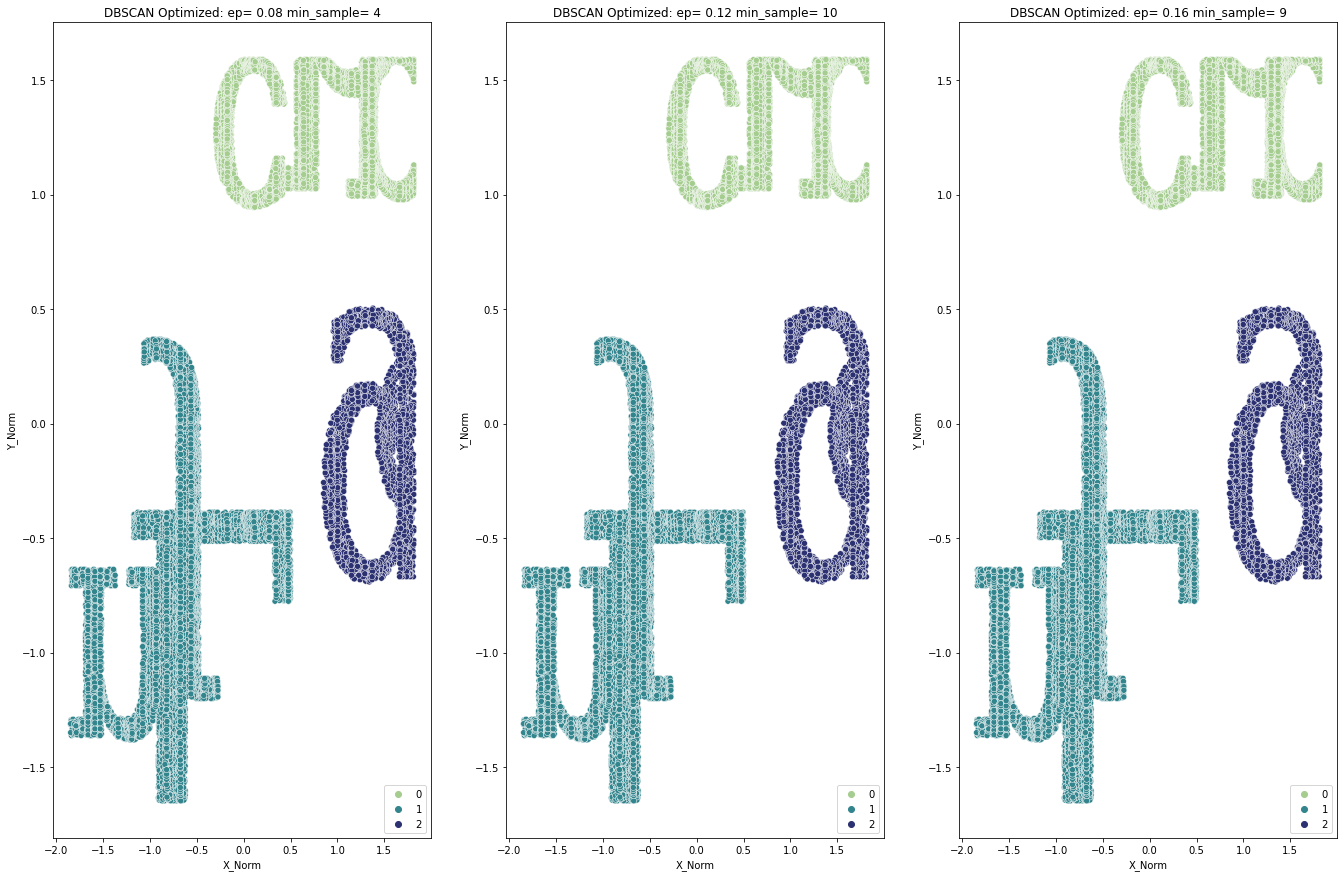

In [23]:
set_parameters=[(0.08,4),(0.12,10),(0.16,9)]


fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(23,15))

for parameter,axis in zip(set_parameters,axes):
  dbscan_opt=DBSCAN(parameter[0],parameter[1])

  pred=dbscan_opt.fit_predict(df_norm_poly[["X_Norm","Y_Norm","X_Norm2","Y_Norm2"]])
  sns.scatterplot(ax=axis,x=df_norm[pred!=-1].X_Norm,y=df_norm[pred!=-1].Y_Norm,hue=pred[pred!=-1],palette="crest")
  
  axis.legend(loc="lower right")
  axis.set_title(f"DBSCAN Optimized: ep= {parameter[0]} min_sample= {parameter[1]}")


plt.show()


From the above subplots, we can see that different set of parameters which gave a score of <strong>3.42</strong> also gave the same clustering distribution. 


Another observation we have is that the <strong>upper left </strong> points that were wrongly assigned to another cluster using KMeans, are here considered <strong>outliers</strong> as an <strong> entity </strong>. That is why we will consider them as a cluster itself !

Text(0.5, 1.0, 'Final Clustering Using DBSCAN ')

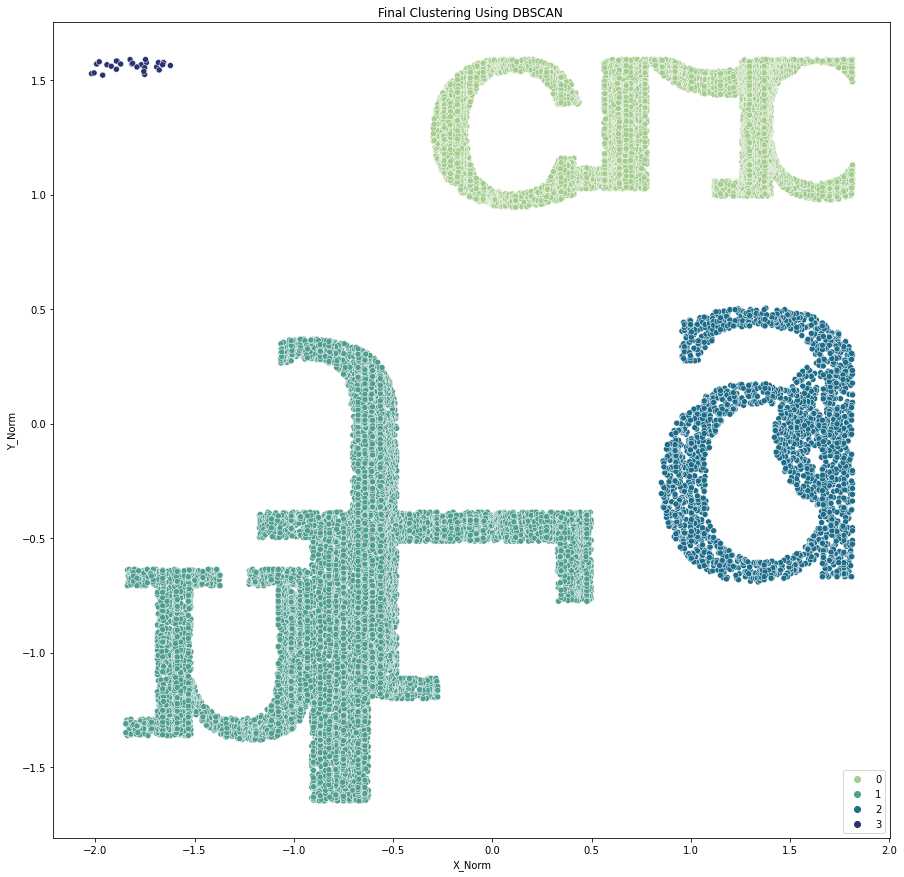

In [24]:
plt.figure(figsize=(15,15))
pred[pred==-1]=3
sns.scatterplot(x=df_norm.X_Norm,y=df_norm.Y_Norm,hue=pred,palette="crest")
plt.legend(loc="lower right")
plt.title("Final Clustering Using DBSCAN ")

#Hierarichal Agglomerative Clustering

In [25]:
from tqdm import tqdm
linkages=["ward","complete","average","single"]
affinities=["euclidean","manhattan","cosine","l1","l2"]
n_clusters=[i for i in range(2,6)]

best_score=0
best_hac_model=None

for link in tqdm(linkages):
  for aff in affinities:
    for n_cluster in n_clusters:
      if link=="ward":
        if aff=="euclidian":
          hac_model=AgglomerativeClustering(n_clusters=n_cluster,affinity=aff,linkage=link)
          pred=hac_model.fit_predict(df_norm_poly[["X_Norm","Y_Norm","X_Norm2","Y_Norm2"]]) 
          sil_euclidian=silhouette_score(df_norm,pred)
          sil_manhattan=silhouette_score(df_norm,pred,metric="manhattan")
          sil_cosine=silhouette_score(df_norm,pred,metric="cosine")
          davies_bouldin=davies_bouldin_score(df_norm,pred)
          if max(float(round(custom_score(sil_euclidian,sil_manhattan,sil_cosine,davies_bouldin),3)),best_score)>float(best_score):
            try:
              print(f"{n_cluster}   {aff}  {link}")
              best_score=max((custom_score(silhouette_euclidian,silhouette_manhattan,silhouette_cosine,davies_bouldin),3),best_score)
              print(best_score)
              best_hac_model=hac_model  
            except Exception as e:
              pass 

      else:
        hac_model=AgglomerativeClustering(n_clusters=n_cluster,affinity=aff,linkage=link)
        pred=hac_model.fit_predict(df_norm_poly[["X_Norm","Y_Norm","X_Norm2","Y_Norm2"]]) 
        sil_euclidian=silhouette_score(df_norm,pred)
        sil_manhattan=silhouette_score(df_norm,pred,metric="manhattan")
        sil_cosine=silhouette_score(df_norm,pred,metric="cosine")
        davies_bouldin=davies_bouldin_score(df_norm,pred)
        if max(float(round(custom_score(sil_euclidian,sil_manhattan,sil_cosine,davies_bouldin),3)),best_score)>float(best_score):
          try:
            print(f"{n_cluster}   {aff}  {link}")
            print(best_score)
            best_score=max(round(custom_score(silhouette_euclidian,silhouette_manhattan,silhouette_cosine,davies_bouldin),3),best_score)
            print(best_score)
            best_hac_model=hac_model  
          except Exception as e:
            pass 

  0%|          | 0/4 [00:00<?, ?it/s]

2   euclidean  complete
0
2.317
5   cosine  complete
2.317
2.317


 50%|█████     | 2/4 [06:29<06:29, 194.84s/it]

3   euclidean  average
2.317
3.374
4   euclidean  average
3.374
3.417
4   manhattan  average
3.417
3.417
2   cosine  average
3.417
3.417
4   l1  average
3.417
3.417
3   l2  average
3.417
3.417
4   l2  average
3.417
3.417


 75%|███████▌  | 3/4 [12:59<04:13, 253.23s/it]

4   euclidean  single
3.417
3.417
5   euclidean  single
3.417
3.417
4   manhattan  single
3.417
3.417
5   manhattan  single
3.417
3.417
3   cosine  single
3.417
3.417
4   cosine  single
3.417
3.417
5   cosine  single
3.417
3.417
4   l1  single
3.417
3.417
5   l1  single
3.417
3.417
4   l2  single
3.417
3.417


100%|██████████| 4/4 [17:29<00:00, 262.39s/it]

5   l2  single
3.417
3.417


After running the grid search on the hierarichal agglomerative clustering model, we see that the score is converging towards the value: <strong>3.414</strong>. 

Let us try of such optimal parameters.

In [ ]:
pred=AgglomerativeClustering(n_clusters=4,affinity="l2",linkage="single").fit_predict(df_norm_poly[["X_Norm","Y_Norm","X_Norm2","Y_Norm2"]])

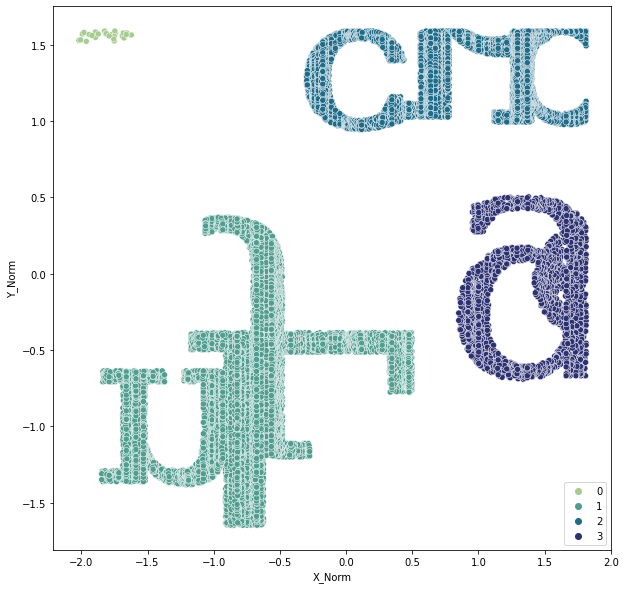

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=df_norm.X_Norm,y=df_norm.Y_Norm,hue=pred,palette="crest")
plt.legend(loc="lower right")

From the above resulted plot we can see that the optimital parameters of the hierichal aggloremative clustering gave us the same cluster spiltting than the one we got from the optimal DBSCAN model and which are visually conveniant.